In [1]:
version = 'v20250521'

## focus on lucas measurements

In [2]:
import pandas as pd
df = pd.read_parquet(f'./material/soc.topsoil_organized_{version}.pq')
print(df.shape)

df = df.loc[df['ref']=='LUCAS']
print(df.shape)

# use carbon to nitrogen ratio
df['c/n'] = df['soc']/df['total.n']

(87684, 420)
(62437, 420)


## organize time series
- only focus on 3-pnt series

In [3]:
lid = df.groupby('id').filter(lambda x: len(x) == 3)['id'].unique().tolist() 
    
tcol = ['lat', 'lon', 'time', 'soc', 'c/n','lc_survey'] # time series cols
scol = ['id', 'ref', 'nuts0'] # static cols
mcol = ['lat', 'lon'] # cols that needs to take the average of the time series

from skmap.misc import TimeTracker, ttprint

ttprint('start organizing')
tsdf = pd.DataFrame(columns=scol + [i+'_mean' for i in mcol] + [i+'_series' for i in tcol])
for iid in lid:
    temp = df.loc[df['id'] == iid].sort_values(by=['time'])  
    
    # Extract static values (first row of static columns)
    static_vals = temp.iloc[0][scol].tolist()
    
    # Compute mean values for columns requiring averaging
    mean_vals = temp[mcol].mean().tolist()
    
    # Extract time series values as lists
    ts_vals = [temp[itcol].tolist() for itcol in tcol]
    
    # Concatenate all extracted values
    tsdf.loc[len(tsdf)] = static_vals + mean_vals + ts_vals
    
ttprint('finish organizing')
print(tsdf.shape)
tsdf.to_parquet(f'./material/srs_lucas.all_{version}.pq')

[12:12:12] start organizing
[12:13:43] finish organizing
(13429, 11)


## calculate time series features


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import geopy.distance
from sklearn.linear_model import HuberRegressor, TheilSenRegressor

# tsdf = pd.read_csv('./material/soc_time.series_lucas.csv')

# filter
dist = [] # distance between two consecutive samples
lcs = [] # land cover series
cn_std = []

# change
trend_class = [] # increase, decrease or varing
fluctuate = [] # maximum soc absolute change

# slope estimation
huber = HuberRegressor(alpha=0.0, epsilon=1)
tsr = TheilSenRegressor(random_state=42)
slope = [] # linear slope
intercept = [] # linear intercept
score = [] # R2 of predicted linear time series
pts = [] # predicted linear time series from linear estimator
d_threshold = 0.5  # Define a threshold for stability


for index, row in tsdf.iterrows():
    soc = row['soc_series']
    time = row['time_series']
    cns = row['c/n_series']
    cn_std.append(np.std(cns))
    
    colat = row['lat_series']
    colon = row['lon_series']
    
    # distance
    dist.append([geopy.distance.geodesic((colon[0], colat[0]),(colon[1], colat[1])).m,
                 geopy.distance.geodesic((colon[1], colat[1]),(colon[2], colat[2])).m])
    
    # soc change
    fluctuate.append([soc[1]-soc[0],soc[2]-soc[1]])
    
    # soc time series
    if (soc[2] > soc[1]) and (soc[1] > soc[0]):
        trend_class.append('increasing')
    elif (soc[2] < soc[1]) and (soc[1] < soc[0]):
        trend_class.append('decreasing')
    else:
        trend_class.append('varing')
        
    # land cover
    lcs.append(row['lc_survey_series'])
        
    # fit linear slope
    X = np.array(time)-2009
    tsr.fit(X.reshape(-1, 1), np.array(soc))
    slope.append(tsr.coef_[0])
    intercept.append(tsr.intercept_)
    score.append(tsr.score(X.reshape(-1, 1), np.array(soc)))
    pts.append(tsr.predict(X.reshape(-1, 1)))

tsdf['distance'] = dist
tsdf['lc'] = lcs
tsdf['cn_std'] = cn_std

tsdf['trend_class'] = trend_class
tsdf['fluctuation'] = fluctuate

tsdf['ts_slope'] = slope
tsdf['ts_intercept'] = intercept
tsdf['ts_score'] = score
tsdf['linear_ts'] = pts

print(tsdf.shape)

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


(13429, 20)


/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [5]:
tsdf['dist_max'] = tsdf['distance'].apply(np.max)
print(tsdf.shape)

(13429, 21)


## Filter

(11831, 21)


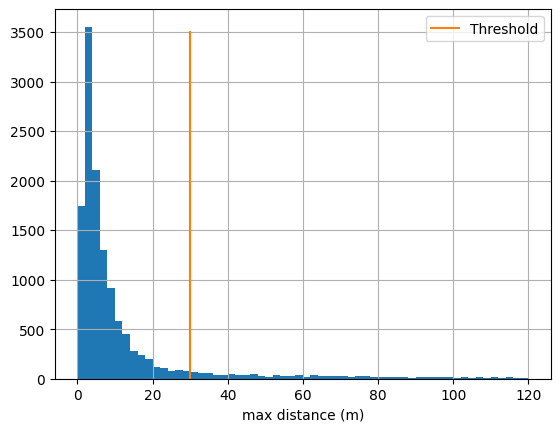

In [6]:
# distance filter
tsdf['dist_max'].hist(bins=60, range=[0,120])
plt.plot([30,30],[0,3500],label='Threshold')
plt.xlabel('max distance (m)')
plt.legend()

ts = tsdf.loc[tsdf['dist_max']<30]
# ol = tsdf.loc[tsdf['dist_max']>=40]
print(ts.shape)

(10204, 21)


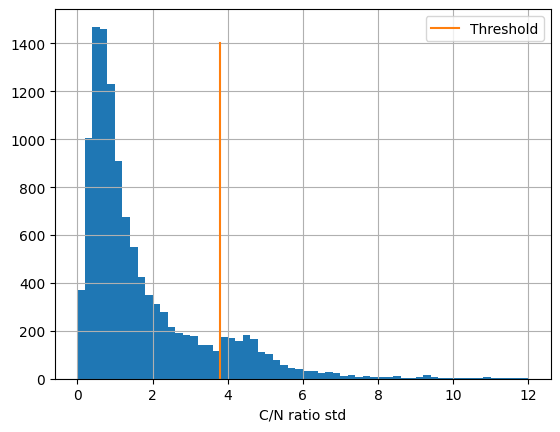

In [7]:
# carbon to nitrogen ratio filter
ts['cn_std'].hist(bins=60, range=[0,12])
plt.plot([3.8,3.8],[0,1400],label='Threshold')
plt.xlabel('C/N ratio std')
plt.legend()

ts = ts.loc[ts['cn_std']<3.8]
print(ts.shape)

In [8]:
ts.to_parquet(f'./material/srs_lucas.plausible_{version}.pq')

### check data

In [9]:
def assign_lc_class(lcl):
    if len(set(lcl))==1:
        return lcl[0]
    else:
        return lcl[0]+'-'+lcl[1]+'-'+lcl[2]
    
ts['lc_class'] = ts['lc'].apply(assign_lc_class)

In [10]:
ts.value_counts(subset=['lc_class','trend_class'])[0:20]

lc_class                      trend_class
cropland                      varing         2428
woodland                      varing         1750
grassland                     varing          980
cropland                      increasing      668
woodland                      increasing      557
cropland                      decreasing      436
grassland                     increasing      392
woodland                      decreasing      338
grassland-cropland-cropland   varing          201
grassland                     decreasing      185
cropland-cropland-bareland    varing          169
cropland-cropland-grassland   varing          155
cropland-grassland-grassland  varing          108
cropland-bareland-cropland    varing          108
cropland-grassland-cropland   varing           84
grassland-grassland-cropland  varing           72
shrubland                     varing           71
grassland-woodland-woodland   varing           52
grassland-cropland-grassland  varing           52
cropland

In [11]:
len(ts.value_counts(subset=['lc_class']))

101

## sample to get test data

In [12]:
df_sample = ts.sample(n=1800, random_state=42)
print(df_sample.shape)

with open(f'./material/srs.id_test_{version}.txt', 'w') as file:
    for number in df_sample['id']:
        file.write(f"{number}\n")
        
# df_sample.to_parquet(f'./material/srs_test_{version}.pq')

(1800, 22)


### location check

In [14]:
ts[ts.columns[0:13]].to_csv('./material/srs_location_check.csv')